<a href="https://colab.research.google.com/github/simonepascucci/progettoLAB-IA/blob/main/ANPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytesseract
!pip install easyocr

In [1]:
import pytesseract
import numpy as np
import cv2
import easyocr
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

!chmod 755 /content/drive/MyDrive/Tesseract-OCR/tesseract.exe
pytesseract.pytesseract.tesseract_cmd = r'/content/drive/MyDrive/Tesseract-OCR/tesseract.exe'

In [2]:
def display(img, title):
  print(title)
  cv2_imshow(img)

Input image:


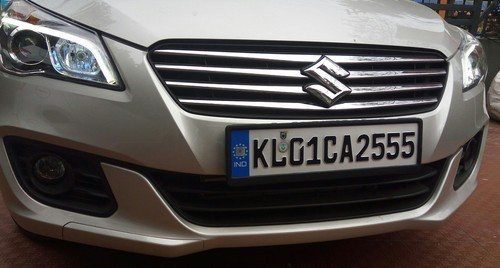

In [59]:
img = cv2.imread('/content/drive/MyDrive/carsDataset/Cars0.png')
display(img, 'Input image:')

In [60]:
def grayscale(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return gray

def noiseReduction(img, mode):
  if mode == '__bfilter__':
    res = cv2.bilateralFilter(img, 11, 75, 75)
    return res
  
  elif mode == '__gauss__':
    res = cv2.GaussianBlur(img, (5,5), 0)
    return res
  
  elif mode == '__median__':
    res = cv2.medianBlur(img, 5)
    return res
  else:
    return img

def edgeDetector(img):
  edged = cv2.Canny(img, 30, 200)
  return edged

def plateExtraction(edged, gray, original):
  contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  img1 = original.copy()
  contours = sorted(contours, key=cv2.contourArea, reverse=True)[:50]
  cv2.drawContours(img1, contours, -1, (0,0,255), 2)
  display(img1, '4 - Finding image contours')
  plate_cnt = None
  plate = None
  for cnt in contours:
    perimeter = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02 * perimeter, True)
    if len(approx) == 4:
      plate_contour = approx
      x, y, w, h = cv2.boundingRect(cnt)
      plate = gray[y:y+h+1, x:x+w+1]
      break
  return plate

In [61]:
def plateThresholding(p):
  res = cv2.adaptiveThreshold(p, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
  return res

def plateNoiseReduction(plate, mode):
  if mode == '__median__':
    kern = np.ones((1, 1), np.uint8)
    nr_plate = cv2.dilate(plate, kern, iterations=1)
    kern = np.ones((1, 1), np.uint8)
    nr_plate = cv2.erode(nr_plate, kern, iterations=1)
    nr_plate = cv2.morphologyEx(nr_plate, cv2.MORPH_CLOSE, kern)
    nr_plate = cv2.medianBlur(nr_plate, 3)
    return nr_plate
  
  elif mode == '__gauss__':
    res = cv2.GaussianBlur(plate, (3,3), 0)
    return res
  
  elif mode == '__bfilter__':
    res = cv2.bilateralFilter(plate, 11, 17, 17)
    return res
  
  else:
    return plate

1 - Converting to grayscale


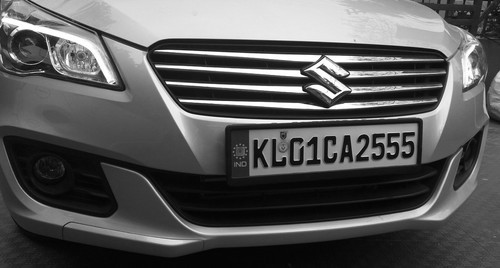

In [62]:
gray = grayscale(img)
display(gray, '1 - Converting to grayscale')

2 - Noise reduction (Bilateral filter)


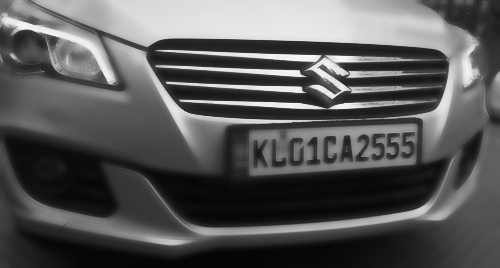

(Gaussian blur)


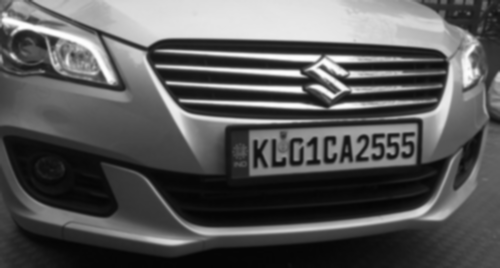

(Median blur)


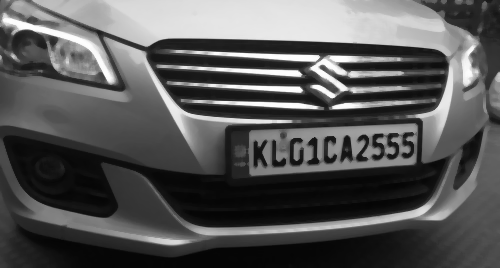

In [63]:
smooth1 = noiseReduction(gray, '__bfilter__')
smooth2 = noiseReduction(gray, '__gauss__')
smooth3 = noiseReduction(gray, '__median__')
display(smooth1, '2 - Noise reduction (Bilateral filter)')
display(smooth2, '(Gaussian blur)')
display(smooth3, '(Median blur)')

3 - Edge detection with Canny edge detector


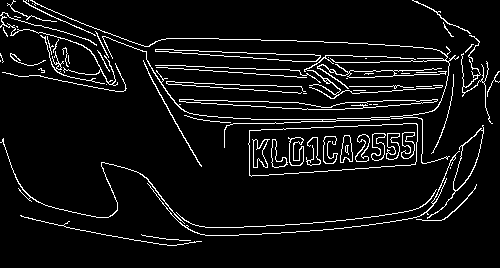

In [64]:
edged = edgeDetector(smooth1)
# edged = edgeDetector(smooth1)
# edged = edgeDetector(smooth1)
display(edged, '3 - Edge detection with Canny edge detector')

4 - Finding image contours


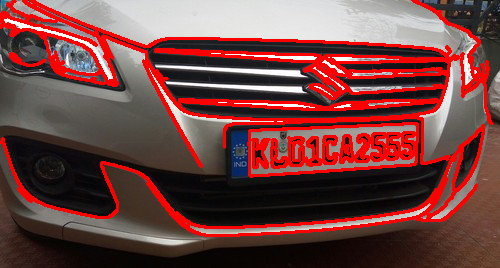

5 - Plate extraction


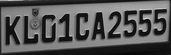

In [65]:
plate = plateExtraction(edged, gray, img)
if plate.any():
  display(plate, '5 - Plate extraction')

6 - Plate pre-processing before OCR

6.1 - Plate thresholding binarization


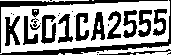


6.2 - Plate noise reduction 
Median blur + erosion + dilation


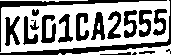


Bilateral filter


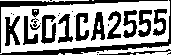


Gaussian blur


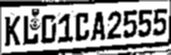

In [66]:
print('6 - Plate pre-processing before OCR')
print()

thresh_p = plateThresholding(plate)
display(thresh_p, '6.1 - Plate thresholding binarization')

nr_plate1 = plateNoiseReduction(thresh_p, '__median__')
nr_plate2 = plateNoiseReduction(thresh_p, '__bfilter__')
nr_plate3 = plateNoiseReduction(thresh_p, '__gauss__')
print()
print('6.2 - Plate noise reduction ')
display(nr_plate1, 'Median blur + erosion + dilation')
print()
display(nr_plate2, 'Bilateral filter')
print()
display(nr_plate3, 'Gaussian blur')

In [77]:
reader = easyocr.Reader(['it'])
text1 = reader.readtext(nr_plate1)
text2 = reader.readtext(nr_plate2)
text3 = reader.readtext(nr_plate3)
text4 = reader.readtext(plate)

print(text1)
print(text2)
print(text3)
print(text4)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete[([[0, 0], [171, 0], [171, 53], [0, 53]], 'KLGICA2555', 0.5509443355088506)]
[([[0, 0], [171, 0], [171, 52], [0, 52]], 'KLGZCA2555', 0.31529157359428783)]
[([[0, 0], [171, 0], [171, 55], [0, 55]], 'KEGICA2555', 0.5845550295352548)]
[([[0, 0], [171, 0], [171, 53], [0, 53]], 'KLGICA2555', 0.7449118209266593)]


meothod2


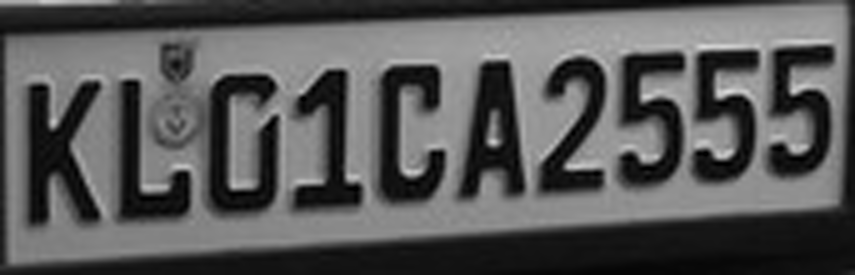

In [68]:
from scipy.ndimage import interpolation
p2 = cv2.resize(plate, None, fx=5, fy=5, interpolation=cv2.INTER_CUBIC)
display(p2, 'meothod2')

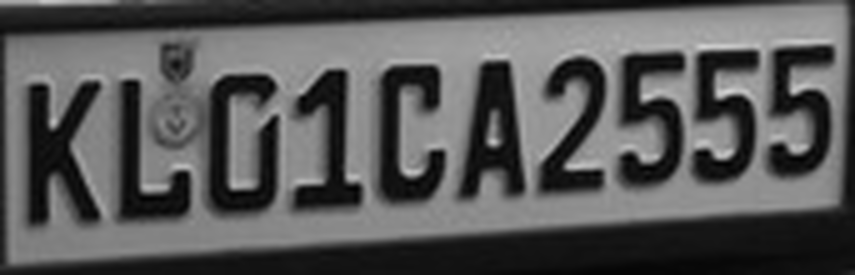

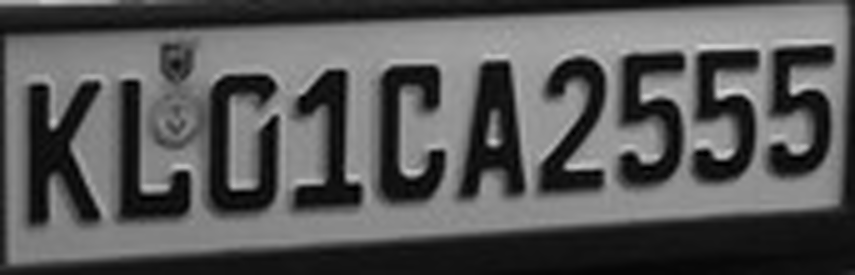

otsu


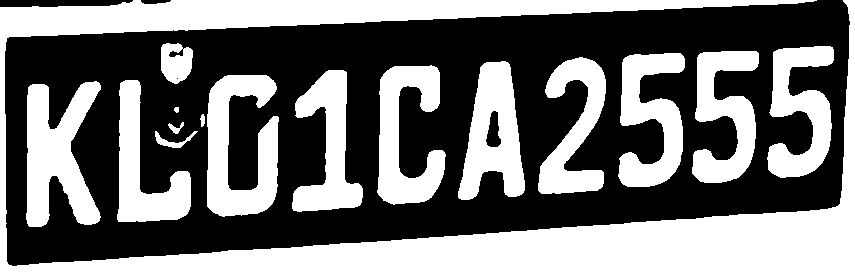

dilation


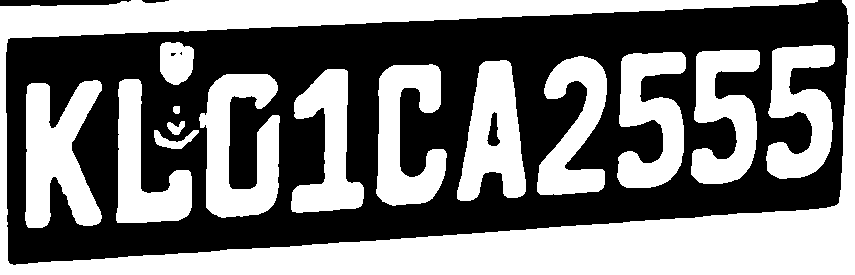

In [69]:
gblur = cv2.GaussianBlur(p2, (5,5), 0)
mblur = cv2.medianBlur(p2, 3)
display(gblur,'')
display(mblur,'')
ret, thresh = cv2.threshold(gblur, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
display(thresh, 'otsu')
rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
dilation = cv2.dilate(thresh, rect_kern, iterations = 1)
display(dilation, 'dilation')

contours


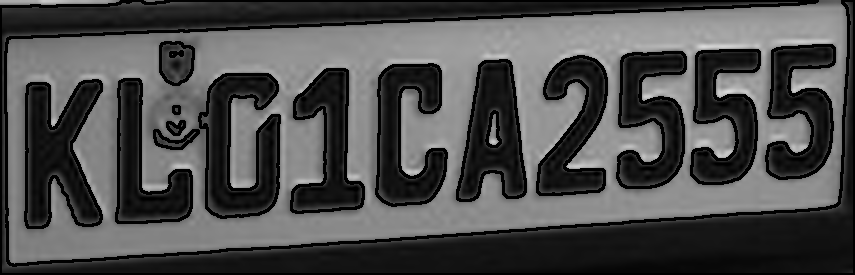

In [70]:
try:
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
except:
    ret_img, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
im_cnts = p2.copy()
im_cnts = cv2.drawContours(im_cnts, contours, -1, (0,0,255), 2)
display(im_cnts, 'contours')

[]


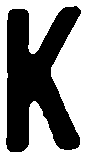

[([[0, 6], [86, 6], [86, 144], [0, 144]], 'l', 0.866561451872272)]


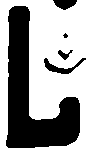

[([[0, 8], [91, 8], [91, 148], [0, 148]], '0', 0.24427775933020612)]


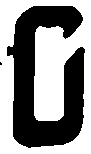

[([[1, 5], [83, 5], [83, 153], [1, 153]], '1', 0.9999446876545335)]


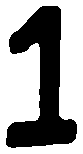

[([[0, 11], [81, 11], [81, 145], [0, 145]], 'C', 0.9203196954533723)]


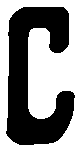

[([[0, 2], [79, 2], [79, 146], [0, 146]], 'A', 0.9808234797444335)]


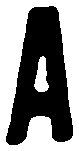

[([[3, 3], [80, 3], [80, 145], [3, 145]], '2', 0.9999997615814351)]


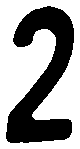

[([[1, 7], [79, 7], [79, 141], [1, 141]], '5', 0.9996753002570244)]


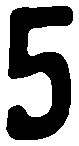

[([[0, 4], [79, 4], [79, 136], [0, 136]], '5', 0.9999954700521272)]


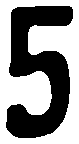

[([[0, 7], [79, 7], [79, 139], [0, 139]], '5', 0.9999367008689752)]


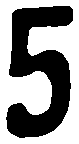

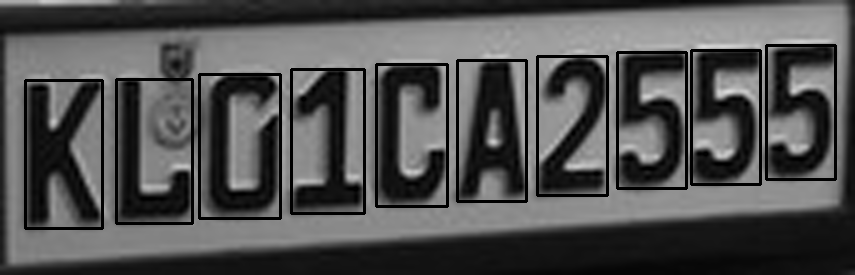

In [78]:
im2 = p2.copy()
plate_num = ""
# loop through contours and find letters in license plate
for cnt in sorted_contours:
    x,y,w,h = cv2.boundingRect(cnt)
    height, width = im2.shape
    
    # if height of box is not a quarter of total height then skip
    if height / float(h) > 4: continue
    ratio = h / float(w)
    # if height to width ratio is less than 1.5 skip
    if ratio < 1.5: continue
    area = h * w
    # if width is not more than 25 pixels skip
    if width / float(w) > 32: continue
    # if area is less than 100 pixels skip
    if area < 100: continue
    # draw the rectangle
    rect = cv2.rectangle(im2, (x,y), (x+w, y+h), (0,255,0),2)
    roi = thresh[y-5:y+h+5, x-5:x+w+5]
    roi = cv2.bitwise_not(roi)
    roi = cv2.medianBlur(roi, 5)
    display( roi, reader.readtext(roi))
display(im2, '')

In [79]:
print(reader.readtext(im_cnts)[0][-2])

KEGICA2555
